In [22]:
import numpy as np
import struct
import os
import matplotlib.pyplot as plt

In [23]:
k = 10
iters = 10
alpha = 0.5
lam = 1

### 导入数据

In [24]:
def load_mnist(file_dir, is_images='True'):
    # Read binary data
    bin_file_name=os.listdir(file_dir)[0]   # get the only data name from current directory
    bin_file=open(os.path.join(file_dir, bin_file_name), 'rb')
    # bin_file = open(file_dir, 'rb')    # old method to read the directory
    bin_data = bin_file.read()
    bin_file.close()
    # Analysis file header
    if is_images:
        # Read images
        fmt_header = '>iiii'
        magic, num_images, num_rows, num_cols = struct.unpack_from(fmt_header, bin_data, 0)
    else:
        # Read labels
        fmt_header = '>ii'
        magic, num_images = struct.unpack_from(fmt_header, bin_data, 0)
        num_rows, num_cols = 1, 1
    data_size = num_images * num_rows * num_cols
    mat_data = struct.unpack_from('>' + str(data_size) + 'B', bin_data, struct.calcsize(fmt_header))
    mat_data = np.reshape(mat_data, [num_images, num_rows * num_cols])
    print('Load images from %s, number: %d, data shape: %s' % (file_dir, num_images, str(mat_data.shape)))
    return mat_data

def data_convert(x, y, m, k):
    x[x<=40]=0
    x[x>40]=1
    ont_hot_y = np.zeros((m,k))    
    for t in np.arange(0,m):
        ont_hot_y[t,y[t]]=1    # expand 1D label to 2D one-hot label
    ont_hot_y=ont_hot_y.T
    return x, ont_hot_y

def load_data(mnist_dir, train_data_dir, train_label_dir, test_data_dir, test_label_dir):
    print('Loading MNIST data from files...')
    train_images = load_mnist(os.path.join(mnist_dir, train_data_dir), True)
    train_labels = load_mnist(os.path.join(mnist_dir, train_label_dir), False)
    test_images = load_mnist(os.path.join(mnist_dir, test_data_dir), True)
    test_labels = load_mnist(os.path.join(mnist_dir, test_label_dir), False)
    return train_images, train_labels, test_images, test_labels

In [29]:
mnist_dir = "mnist_data/"
train_data_dir = "train-images-idx3-ubyte"
train_label_dir = "train-labels-idx1-ubyte"
test_data_dir = "t10k-images-idx3-ubyte"
test_label_dir = "t10k-labels-idx1-ubyte"

# get the data
train_images, train_labels, test_images, test_labels = load_data(mnist_dir, train_data_dir, train_label_dir, test_data_dir, test_label_dir)


Loading MNIST data from files...
Load images from mnist_data/train-images-idx3-ubyte, number: 60000, data shape: (60000, 784)
Load images from mnist_data/train-labels-idx1-ubyte, number: 60000, data shape: (60000, 1)
Load images from mnist_data/t10k-images-idx3-ubyte, number: 10000, data shape: (10000, 784)
Load images from mnist_data/t10k-labels-idx1-ubyte, number: 10000, data shape: (10000, 1)


In [30]:
print("train_images.shpae: ", train_images.shape);
print("train_labels.shpae: ", train_labels.shape);
print("test_images.shpae: ", test_images.shape);
print("test_labels.shpae: ", test_labels.shape);

train_images.shpae:  (60000, 784)
train_labels.shpae:  (60000, 1)
test_images.shpae:  (10000, 784)
test_labels.shpae:  (10000, 1)


In [31]:
m, n = train_images.shape
x, y = data_convert(train_images, train_labels, m, k) # x:[m,n], y:[k,m]

In [32]:
print("x.shpae: ", x.shape);
print("y.shpae: ", y.shape);

x.shpae:  (60000, 784)
y.shpae:  (10, 60000)


x.shpae:  (60000, 28, 28, 1)


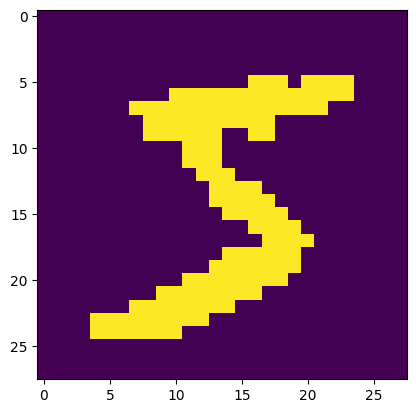

In [38]:
x = x.reshape(m, 1, 28, 28).transpose(0,2,3,1)
print("x.shpae: ", x.shape);

plt.imshow(x[0,:,:,0])

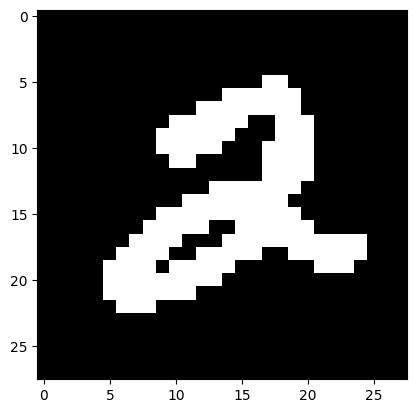

y[0]:  [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]


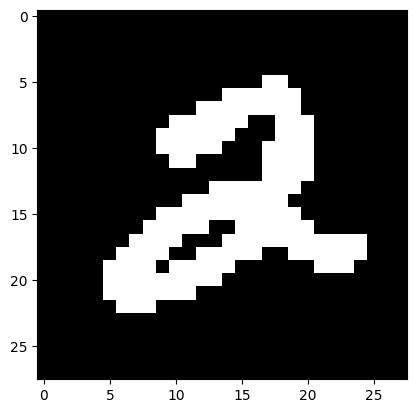

train_labels[0]:  [2]


In [37]:
plt.imshow(x[5].reshape(28,28), cmap='gray')
plt.show()

print("y[0]: ", y[:,5])

plt.imshow(train_images[5].reshape(28,28), cmap='gray')
plt.show()

print("train_labels[0]: ", train_labels[5])

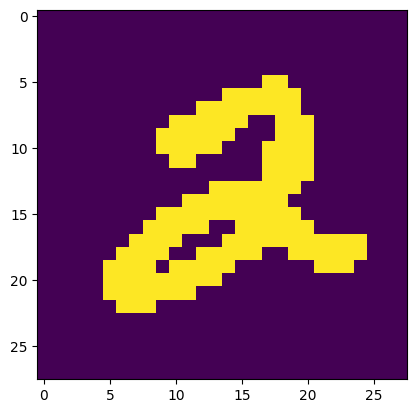

In [35]:
plt.imshow(x[5,:].reshape(28,28))

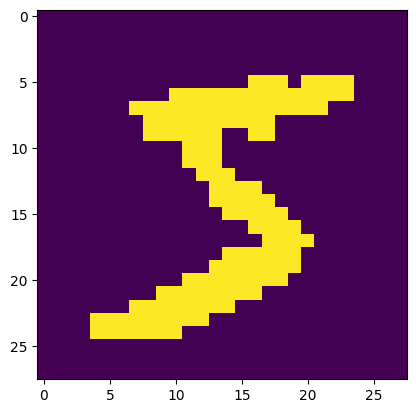

In [36]:
plt.imshow(np.reshape(train_images[0,:],(28,28)))

## 训练$\theta$

### 参数设置

### softmax regression

这里的矩阵z对应为求出的hypothesis矩阵，规模为kxm，每一列为分类的概率，因此softmax在列上求和即可

In [131]:
def softmax(z):
    z-=np.max(z)
    softmax=(np.exp(z) / np.sum(np.exp(z), axis=0))
    return softmax


In [26]:
array_test=np.array([[7,4,1],[2,3,4],[5,2,9],[6,1,7]])

In [27]:
array_test

array([[7, 4, 1],
       [2, 3, 4],
       [5, 2, 9],
       [6, 1, 7]])

In [28]:
softmax(array_test)

array([[6.62272414e-01, 6.43914260e-01, 2.93645024e-04],
       [4.46235642e-03, 2.36882818e-01, 5.89801797e-03],
       [8.96288247e-02, 8.71443187e-02, 8.75343479e-01],
       [2.43636405e-01, 3.20586033e-02, 1.18464858e-01]])

In [29]:
softmax(array_test).argmax(axis=0)

array([0, 0, 2])

x规模为mxn

y规模为kxm

theta规模为kxn

In [132]:
def get_gradient(x, y, theta, lam):
    m = x.shape[0]
    score = np.dot(theta, x.T)
    softmax_score = softmax(score)
    # gradient = np.dot(softmax_score-y,x)/m + lam*theta
    # loss=(-1/m)*np.sum(np.dot(y,np.log(prob)))+(lam/2)*np.sum(theta*theta)
    # grad=(-1/m)*np.dot((y-prob.T),x) + lam*theta
    gradient = np.dot(softmax_score-y,x)/m
    return gradient

In [133]:
def softmax_regression(theta, x, y, iters, alpha, lam):
    # TODO: Do the softmax regression by computing the gradient and 
    # the objective function value of every iteration and update the theta
    for iter in range(iters):
        gradient=get_gradient(x,y,theta,lam)
        theta=theta-alpha*gradient
    return theta

In [150]:
np.sum(get_gradient(x,y,np.zeros((k,n)),lam))

5.773159728050814e-15

In [152]:
theta=softmax_regression(np.random.rand(k,n),x,y,iters,alpha,lam)

In [134]:
theta=softmax_regression(np.zeros((k,n)),x,y,iters,alpha,lam)

In [135]:
np.sum(theta)

-1.8973538018496328e-19

In [146]:
np.sum(train_images)

7834541

In [145]:
np.sum(x)

7834541

### 训练
x规模为mxn

y规模为kxm

$\theta$规模为kxn

In [119]:
def train(train_images, train_labels, k, iters = 5, alpha = 0.5, lam=0.1):
    m, n = train_images.shape
    # data processing
    x, y = data_convert(train_images, train_labels, m, k) # x:[m,n], y:[k,m]
    
    # Initialize theta.  Use a matrix where each column corresponds to a class,
    # and each row is a classifier coefficient for that class.
    theta = np.random.rand(k, n) # [k,n]
    # do the softmax regression
    theta = softmax_regression(theta, x, y, iters, alpha, lam)
    return theta

In [120]:
theta=train(train_images, train_labels, k, iters = 5, alpha = 0.5, lam=0.1)

In [126]:
np.sum(train_images)

0

In [122]:
np.sum(theta)

3953.785176732537

### 预测

In [141]:
def predict(test_images, theta):
    scores = np.dot(theta, test_images.T)
    preds = np.argmax(scores, axis=0)
    return preds

def cal_accuracy(y_pred, y):
    # TODO: Compute the accuracy among the test set and store it in acc
    acc=0
    for i in range(y.shape[0]):
        if y_pred[i] == y[i]:
            acc += 1
    return acc/y.shape[0]

In [153]:
y_predict = predict(test_images, theta)
accuracy  = cal_accuracy(y_predict, test_labels)

In [154]:
accuracy

0.6286